# 1. Introduction

# 2. Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import seaborn as sns

import re
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"DEVICE: {device}")

DEVICE: cuda


# 3. Utils

## 3.1. Common

In [ ]:
# def evaluate_model(model, loader, device):
#     model.eval()
#     correct = 0
#     with torch.no_grad():
#         for data, target in loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
#     return 100. * correct / len(loader.dataset)

# def run_training(model, epochs, train_loader, test_loader, device, name):
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     print(f"\n>>> Training: {name}")

#     for epoch in range(1, epochs+1):
#         model.train()
#         for _, (data, target) in enumerate(train_loader):
#             data, target = data.to(device), target.to(device)
#             optimizer.zero_grad()
#             output = model(data)
#             loss = F.cross_entropy(output, target)
#             loss.backward()
#             optimizer.step()

#         acc = evaluate_model(model, test_loader, device)
#         print(f"Epoch {epoch}/{epochs} | Acc: {acc:.2f}%")
#     return acc

def show_sample(image, label):
    
    # Converte o tensor para o formato que o matplotlib entende (28, 28)
    img_display = image.squeeze().numpy()
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img_display, cmap='gray')
    plt.title(f"Label: {label}", fontsize=12)
    plt.axis('off')
    plt.show()
    
    return label

def evaluate_model(model, test_loader, device, name):
    """
    Performs a final evaluation on the unseen test dataset.
    Prints the accuracy and average loss in English.
    """
    model.eval() # Essential: sets the model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # Disables gradient calculation for efficiency
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate cross entropy loss for the batch
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            # Get the predicted class
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"\n[FINAL EVALUATION: {name}]")
    print(f"Test Samples: {len(test_loader.dataset)}")
    print(f"Average Loss: {avg_test_loss:.4f}")
    print(f"Accuracy:     {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")
    
    return accuracy

def run_training(model, epochs, train_loader, val_loader, device, name, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"\n>>> Training: {name}")

    for epoch in range(1, epochs + 1):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- VALIDATION PHASE ---
        model.eval()
        v_loss = 0.0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                v_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = v_loss / len(val_loader.dataset)
        acc = 100. * correct / len(val_loader.dataset)
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        print(f"Epoch {epoch:02d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.2f}%")
        
    return history


# def quantize_8bit(tensor):
#     """
#     Simula a precisão de 8 bits (INT8) mapeando os valores 
#     para 256 níveis discretos entre o valor mínimo e máximo.
#     """
#     detach_tensor = tensor.detach()

#     if tensor.numel() == 0: return tensor
#     min_val, max_val = tensor.min(), tensor.max()
#     # Evita divisão por zero se todos os valores forem iguais
#     if min_val == max_val: return tensor 
    
#     # Mapeia para 0-255, arredonda e volta para a escala original
#     scale = 255.0 / (max_val - min_val)
#     q_tensor = torch.round((tensor - min_val) * scale) / scale + min_val
#     # return q_tensor
#     return tensor + (q_tensor - tensor).detach()


def quantize(tensor, bits=8):
    """
    Simula precisão de N-bits mapeando os valores para (2^bits - 1) níveis.
    Funciona para 8, 16 ou qualquer outra precisão inteira.
    """
    if tensor.numel() == 0: 
        return tensor
    
    # Define o número de níveis (ex: 8 bits = 255, 16 bits = 65535)
    levels = (2**bits) - 1
    
    min_val, max_val = tensor.min(), tensor.max()
    
    # Evita divisão por zero
    if min_val == max_val: 
        return tensor 
    
    # Escalonamento para a faixa dinâmica
    scale = levels / (max_val - min_val)
    
    # Quantização (Forward)
    q_tensor = torch.round((tensor - min_val) * scale) / scale + min_val
    
    # Straight-Through Estimator (STE)
    # No forward usa q_tensor, no backward o gradiente passa direto pelo tensor original
    return tensor + (q_tensor - tensor).detach()

def plot_weights_mlp(mlp_model, n_neurons=20, n_inputs=20):
    """
    Mostra a matriz de pesos de forma comparativa.
    n_neurons e n_inputs definem o 'zoom' na matriz de pesos.
    """
    # Extrai uma amostra dos pesos da primeira camada
    w_mlp = mlp_model.fc1.weight.detach()[:n_neurons, :n_inputs].cpu().numpy()
    
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

    # Mapa de Calor MLP (Floats com gradiente)
    sns.heatmap(w_mlp, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax1, cbar=False)
    ax1.set_title("Weights MLP Baseline (Float32)", fontsize=12)
    ax1.set_xlabel("Inputs (Pixels)")
    ax1.set_ylabel("Hidden Neurons")

    plt.tight_layout()
    plt.show()

def plot_weights_bgn(bgn_model, n_neurons=20, n_inputs=20):
    """
    Mostra a matriz de pesos de forma comparativa.
    n_neurons e n_inputs definem o 'zoom' na matriz de pesos.
    """
    # Extrai uma amostra dos pesos da primeira camada
    w_bgn = bgn_model.layer1.weights.detach()[:n_neurons, :n_inputs].cpu().numpy()
    
    # Aplica a binarização para mostrar o que a FPGA 'vê'
    w_bgn_bin = (w_bgn > 0).astype(float) * 2 - 1 # Converte para -1 e 1

    fig, ax2 = plt.subplots(1, 1, figsize=(16, 6))

    # Mapa de Calor BGN (Binário Bipolar)
    sns.heatmap(w_bgn_bin, annot=True, fmt=".0f", cmap="RdBu", center=0, ax=ax2, cbar=False)
    ax2.set_title("Weights BGN (1-bit Bipolar)", fontsize=12)
    ax2.set_xlabel("Inputs (Pixels)")
    ax2.set_ylabel("Hidden Neurons")

    plt.tight_layout()
    plt.show()


def get_memory_footprint(model):
    """
    Calculates and prints the memory footprint of the model in English.
    Differentiates between 1-bit binary weights and 32-bit float weights.
    """
    total_bits = 0
    total_params = 0
    
    print(f"{'Layer Name':<25} | {'Type':<15} | {'Parameters':<12} | {'Bit-width':<8} | {'Size (KB)':<10}")
    print("-" * 80)
    
    for name, module in model.named_modules():
        # Only process layers with parameters (Linear, BatchNorm, or GroupedGraphLayer)
        if len(list(module.children())) == 0 and (hasattr(module, 'weight') or hasattr(module, 'weights')):
            
            layer_params = 0
            layer_bits = 0
            layer_type = "Float32"
            
            # 1. Handle Binary Weights (Your BGN / GroupedGraphLayer)
            if hasattr(module, 'weights'):
                layer_type = "BGN (1-bit)"
                # Weights are 1-bit bipolar {-1, 1}
                w_params = module.weights.numel()
                layer_params += w_params
                layer_bits += w_params * 1 
                
                # Biases in BGN are usually float32 to maintain precision after Popcount
                if hasattr(module, 'bias') and module.bias is not None:
                    b_params = module.bias.numel()
                    layer_params += b_params
                    layer_bits += b_params * 32
            
            # 2. Handle Standard Layers (MLP Baseline, BatchNorm)
            else:
                if hasattr(module, 'weight') and module.weight is not None:
                    w_params = module.weight.numel()
                    layer_params += w_params
                    layer_bits += w_params * 32
                
                if hasattr(module, 'bias') and module.bias is not None:
                    b_params = module.bias.numel()
                    layer_params += b_params
                    layer_bits += b_params * 32
            
            if layer_params > 0:
                layer_size_kb = layer_bits / (8 * 1024)
                # Fixed formatting: using :, for thousand separators
                print(f"{name:<25} | {layer_type:<15} | {layer_params:<12,} | {layer_bits/layer_params:>8.1f} | {layer_size_kb:>10.2f}")
                
                total_params += layer_params
                total_bits += layer_bits

    total_kb = total_bits / (8 * 1024)
    print("-" * 80)
    print(f"{'TOTAL':<25} | {'':<15} | {total_params:<12,} | {'AVG:':>8} {total_bits/total_params:>4.1f} | {total_kb:>10.2f} KB")
    
    return total_kb

def get_memory_footprint_quantized(model, non_binary_bits=8):
    """
    Calculates memory footprint with Mixed-Precision (1-bit for BGN, X-bits for others).
    All prints are in English.
    """
    total_bits = 0
    total_params = 0
    
    print(f"{'Layer Name':<25} | {'Type':<15} | {'Parameters':<12} | {'Bit-width':<8} | {'Size (KB)':<10}")
    print("-" * 80)
    
    for name, module in model.named_modules():
        if len(list(module.children())) == 0 and (hasattr(module, 'weight') or hasattr(module, 'weights')):
            layer_params = 0
            layer_bits = 0
            
            if hasattr(module, 'weights'): # BGN Layer
                layer_type = "BGN (1-bit)"
                w_params = module.weights.numel()
                layer_params += w_params
                layer_bits += w_params * 1 
                
                if hasattr(module, 'bias') and module.bias is not None:
                    b_params = module.bias.numel()
                    layer_params += b_params
                    layer_bits += b_params * non_binary_bits
            else: # Standard Layers (BN, Linear)
                layer_type = f"INT{non_binary_bits}"
                if hasattr(module, 'weight') and module.weight is not None:
                    w_params = module.weight.numel()
                    layer_params += w_params
                    layer_bits += w_params * non_binary_bits
                
                if hasattr(module, 'bias') and module.bias is not None:
                    b_params = module.bias.numel()
                    layer_params += b_params
                    layer_bits += b_params * non_binary_bits
            
            if layer_params > 0:
                layer_size_kb = layer_bits / (8 * 1024)
                print(f"{name:<25} | {layer_type:<15} | {layer_params:<12,} | {layer_bits/layer_params:>8.1f} | {layer_size_kb:>10.2f}")
                total_params += layer_params
                total_bits += layer_bits

    total_kb = total_bits / (8 * 1024)
    print("-" * 80)
    print(f"{'TOTAL':<25} | {'':<15} | {total_params:<12,} | {'AVG:':>8} {total_bits/total_params:>4.1f} | {total_kb:>10.2f} KB")

def get_memory_footprint_mixed(model):
    """
    Calculates memory footprint with Mixed-Precision:
    - 1-bit for BGN Weights
    - 16-bit for Batch Normalization (Critical for precision)
    - 8-bit for Output/Linear layers
    """
    total_bits = 0
    total_params = 0
    
    print(f"{'Layer Name':<25} | {'Type':<15} | {'Parameters':<12} | {'Bit-width':<8} | {'Size (KB)':<10}")
    print("-" * 82)
    
    for name, module in model.named_modules():
        # Filtra apenas camadas com parâmetros (sem filhos)
        if len(list(module.children())) == 0 and (hasattr(module, 'weight') or hasattr(module, 'weights') or hasattr(module, 'bias')):
            layer_params = 0
            layer_bits = 0
            
            # 1. Lógica para definir a precisão por tipo de camada
            if "layer1" in name: # Camada Binária
                current_bits = 1
                layer_type = "BGN (1-bit)"
            elif "bn" in name:   # Batch Norm (Ajustamos para 16-bit para evitar vício de classe)
                current_bits = 16
                layer_type = "INT16"
            else:                # Demais camadas (Layer 2 / Saída)
                current_bits = 8
                layer_type = "INT8"

            # 2. Contagem de Parâmetros de Pesos
            if hasattr(module, 'weights') and module.weights is not None:
                w_p = module.weights.numel()
                layer_params += w_p
                layer_bits += w_p * 1 # BGN sempre 1-bit
            elif hasattr(module, 'weight') and module.weight is not None:
                w_p = module.weight.numel()
                layer_params += w_p
                layer_bits += w_p * current_bits

            # 3. Contagem de Parâmetros de Bias
            if hasattr(module, 'bias') and module.bias is not None:
                b_p = module.bias.numel()
                layer_params += b_p
                # Bias geralmente segue a precisão da camada (8 ou 16)
                layer_bits += b_p * current_bits
            
            if layer_params > 0:
                layer_size_kb = layer_bits / (8 * 1024)
                avg_w = layer_bits / layer_params
                print(f"{name:<25} | {layer_type:<15} | {layer_params:<12,} | {avg_w:>8.1f} | {layer_size_kb:>10.2f}")
                total_params += layer_params
                total_bits += layer_bits

    total_kb = total_bits / (8 * 1024)
    avg_total_bits = total_bits / total_params if total_params > 0 else 0
    print("-" * 82)
    print(f"{'TOTAL':<25} | {'':<15} | {total_params:<12,} | {'AVG:':>8} {avg_total_bits:>4.1f} | {total_kb:>10.2f} KB")

# Uso:
# get_memory_footprint_mixed(bgn)

import matplotlib.pyplot as plt

def plot_training_results(history, model_name):
    """
    Plots the Training and Validation Loss and Accuracy from the history dictionary.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Training Metrics: {model_name}', fontsize=16)

    # 1. Loss Plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r--', label='Validation Loss', linewidth=2)
    ax1.set_title('Cross Entropy Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # 2. Accuracy Plot
    ax2.plot(epochs, history['val_acc'], 'g-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim(min(history['val_acc']) - 5, 100) # Ajusta escala para ver melhor o topo
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## 3.2. Baseline

In [ ]:
class MLP_Baseline(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden)
        self.fc2 = nn.Linear(hidden, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        weights = self.fc1.weight
        x = F.linear(x, weights, self.fc1.bias)
        x = torch.relu(x)
        return self.fc2(x)

## 3.3. Binary Graph Network

In [ ]:
class BinaryUnpacker(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_tensor):
        ctx.save_for_backward(input_tensor)
        return torch.sign(input_tensor)

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input_tensor.abs() > 1.0] = 0
        return grad_input

class GroupedGraphLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Pesos latentes iniciam em float
        self.weights = nn.Parameter(torch.randn(out_features, in_features) * 0.1)

    def forward(self, x):
        # Transforma pesos latentes em -1 e 1
        binary_weights = BinaryUnpacker.apply(self.weights)
        return F.linear(x, binary_weights)

class MPL_BGN(nn.Module):
    def __init__(self, expansion=10):
        super().__init__()

        # AQUI ESTÁ A EXPANSÃO: o tamanho do 'hidden' cresce com o fator
        self.hidden_size = 128 * expansion 
        
        self.layer1 = GroupedGraphLayer(784, self.hidden_size)
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.drop = nn.Dropout(0.2)
        self.layer2 = nn.Linear(self.hidden_size, 10)

    # def forward(self, x):
    #     x = x.view(-1, 784)
        
    #     # Binarização da entrada (Opcional, mas recomendado para fechar o pipeline)
    #     x = torch.sign(x - 0.5) 
        
    #     x = self.layer1(x) 
    #     x = self.bn1(x)
    #     x = torch.relu(x)
    #     x = self.drop(x)
    #     return self.layer2(x)

    def forward(self, x):
            # 1. Entrada binarizada
            x = x.view(-1, 784)
            x = torch.sign(x - 0.5) 
            
            # 2. Camada de Grafo (Layer 1 - 1 bit)
            x = self.layer1(x) 
            
            # 3. BatchNorm + Quantização (Simulando hardware INT16)
            x = self.bn1(x)
            x = quantize(x, bits=16) # <--- AQUI: O resultado do BN vira 16 bits
            
            x = torch.relu(x)
            x = self.drop(x)
            
            # 4. Saída + Quantização Final
            x = self.layer2(x)
            x = quantize(x, bits=8) # <--- AQUI: A predição final vira 8 bits
            
            return x    

# 4. Dataset

In [87]:
# from torch.utils.data import DataLoader, random_split
# from torchvision import datasets, transforms

# 1. Definição do Transform (Puro, conforme discutimos)
transform = transforms.Compose([
    transforms.ToTensor()
])

# 2. Carregamento dos Datasets Originais
full_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# 3. Divisão do Treino em Treino e Validação (ex: 90% treino, 10% validação)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_subset, val_subset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42) # Seed para reprodutibilidade
)

# 4. Criação dos DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 54000
Validation samples: 6000
Test samples: 10000


# 5. Models

In [317]:
mlp = MLP_Baseline(128).to(device)
bgn = MPL_BGN(expansion=1).to(device)

get_memory_footprint(mlp)
print("\n")
get_memory_footprint_mixed(bgn)

Layer Name                | Type            | Parameters   | Bit-width | Size (KB) 
--------------------------------------------------------------------------------
fc1                       | Float32         | 100,480      |     32.0 |     392.50
fc2                       | Float32         | 1,290        |     32.0 |       5.04
--------------------------------------------------------------------------------
TOTAL                     |                 | 101,770      |     AVG: 32.0 |     397.54 KB


Layer Name                | Type            | Parameters   | Bit-width | Size (KB) 
----------------------------------------------------------------------------------
layer1                    | BGN (1-bit)     | 100,352      |      1.0 |      12.25
bn1                       | INT16           | 256          |     16.0 |       0.50
layer2                    | INT8            | 1,290        |      8.0 |       1.26
-------------------------------------------------------------------------------

# 6. Training


>>> Training: MLP (Baseline)
Epoch 01/10 | Train Loss: 0.3532 | Val Loss: 0.2081 | Val Acc: 93.85%
Epoch 02/10 | Train Loss: 0.1603 | Val Loss: 0.1504 | Val Acc: 95.48%
Epoch 03/10 | Train Loss: 0.1127 | Val Loss: 0.1306 | Val Acc: 96.12%
Epoch 04/10 | Train Loss: 0.0871 | Val Loss: 0.1034 | Val Acc: 97.05%
Epoch 05/10 | Train Loss: 0.0695 | Val Loss: 0.1020 | Val Acc: 97.03%
Epoch 06/10 | Train Loss: 0.0553 | Val Loss: 0.1016 | Val Acc: 97.02%
Epoch 07/10 | Train Loss: 0.0458 | Val Loss: 0.0963 | Val Acc: 97.12%
Epoch 08/10 | Train Loss: 0.0371 | Val Loss: 0.0914 | Val Acc: 97.20%
Epoch 09/10 | Train Loss: 0.0314 | Val Loss: 0.0972 | Val Acc: 97.10%
Epoch 10/10 | Train Loss: 0.0260 | Val Loss: 0.0915 | Val Acc: 97.27%


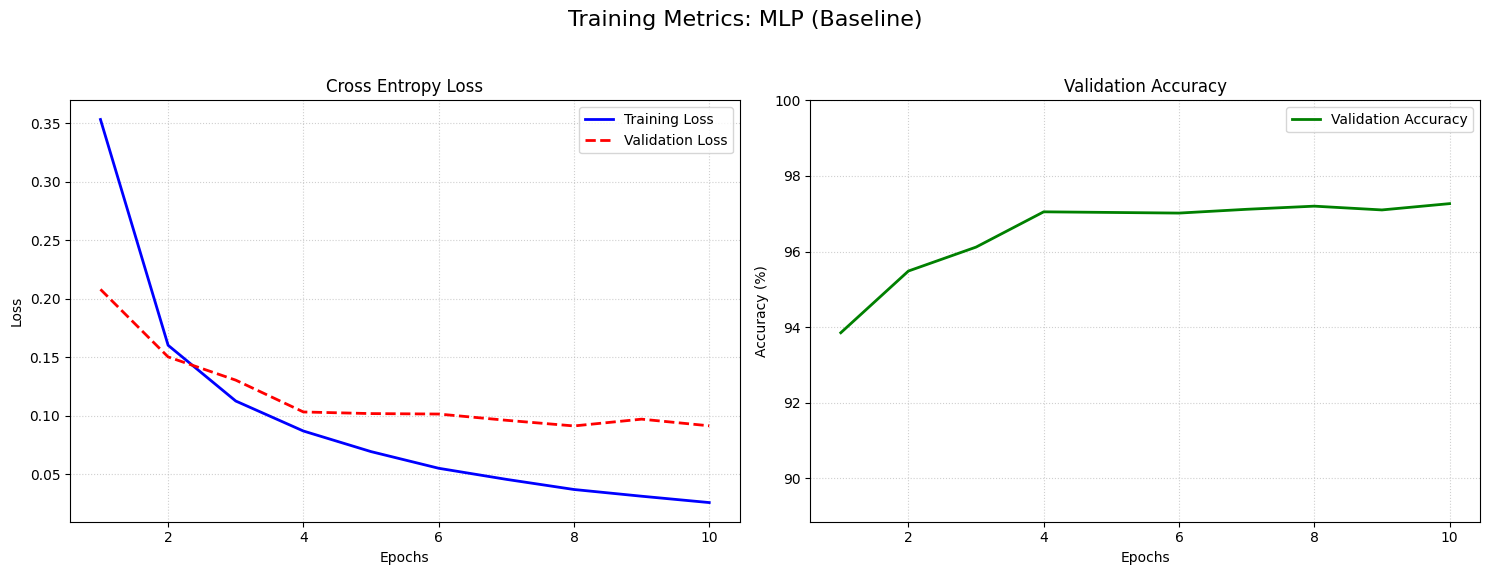

In [318]:

mlp_history = run_training(mlp, 10, train_loader, val_loader, device, name="MLP (Baseline)")
plot_training_results(mlp_history, "MLP (Baseline)")


>>> Training: MLP (BGN)
Epoch 01/15 | Train Loss: 0.6309 | Val Loss: 0.3094 | Val Acc: 90.98%
Epoch 02/15 | Train Loss: 0.2989 | Val Loss: 0.2438 | Val Acc: 92.73%
Epoch 03/15 | Train Loss: 0.2479 | Val Loss: 0.2073 | Val Acc: 94.12%
Epoch 04/15 | Train Loss: 0.2163 | Val Loss: 0.1917 | Val Acc: 94.10%
Epoch 05/15 | Train Loss: 0.1951 | Val Loss: 0.1731 | Val Acc: 94.92%
Epoch 06/15 | Train Loss: 0.1807 | Val Loss: 0.1680 | Val Acc: 94.85%
Epoch 07/15 | Train Loss: 0.1681 | Val Loss: 0.1591 | Val Acc: 95.18%
Epoch 08/15 | Train Loss: 0.1602 | Val Loss: 0.1517 | Val Acc: 95.40%
Epoch 09/15 | Train Loss: 0.1495 | Val Loss: 0.1513 | Val Acc: 95.53%
Epoch 10/15 | Train Loss: 0.1422 | Val Loss: 0.1391 | Val Acc: 95.85%
Epoch 11/15 | Train Loss: 0.1379 | Val Loss: 0.1428 | Val Acc: 95.75%
Epoch 12/15 | Train Loss: 0.1337 | Val Loss: 0.1439 | Val Acc: 95.67%
Epoch 13/15 | Train Loss: 0.1263 | Val Loss: 0.1358 | Val Acc: 95.88%
Epoch 14/15 | Train Loss: 0.1228 | Val Loss: 0.1464 | Val Acc: 95

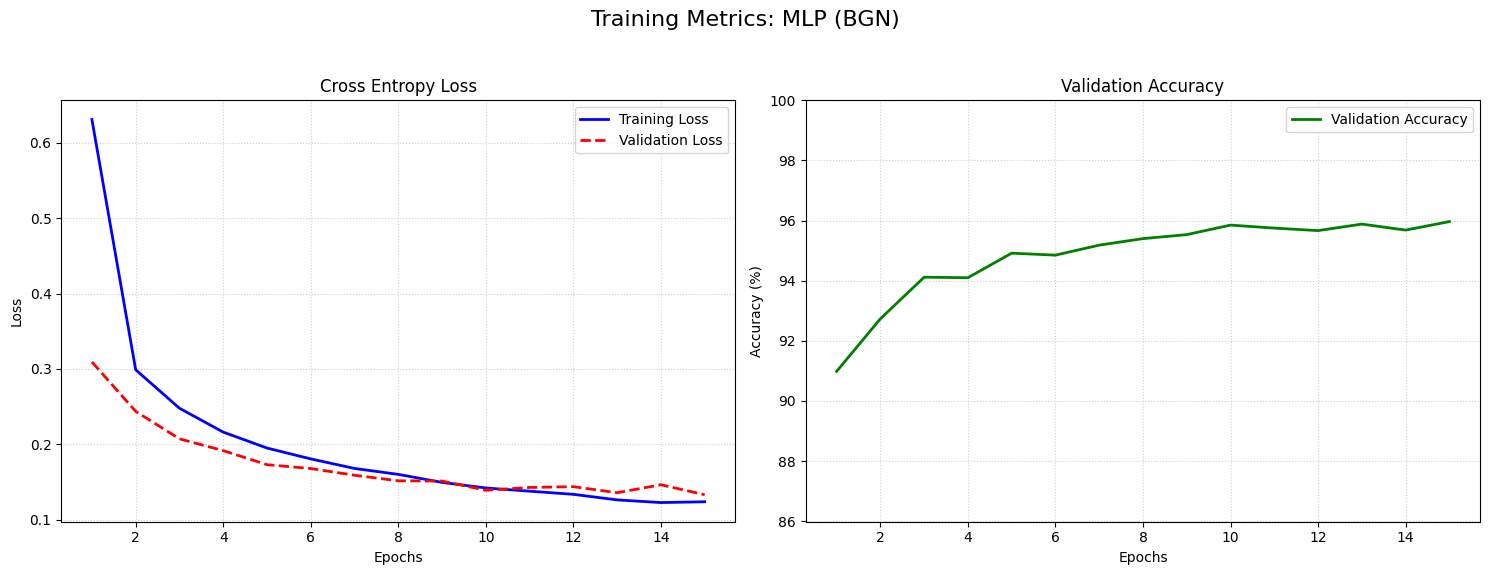

In [319]:
bgn_history = run_training(bgn, 15, train_loader, val_loader, device, name="MLP (BGN)", lr=0.0005)
plot_training_results(bgn_history, "MLP (BGN)")

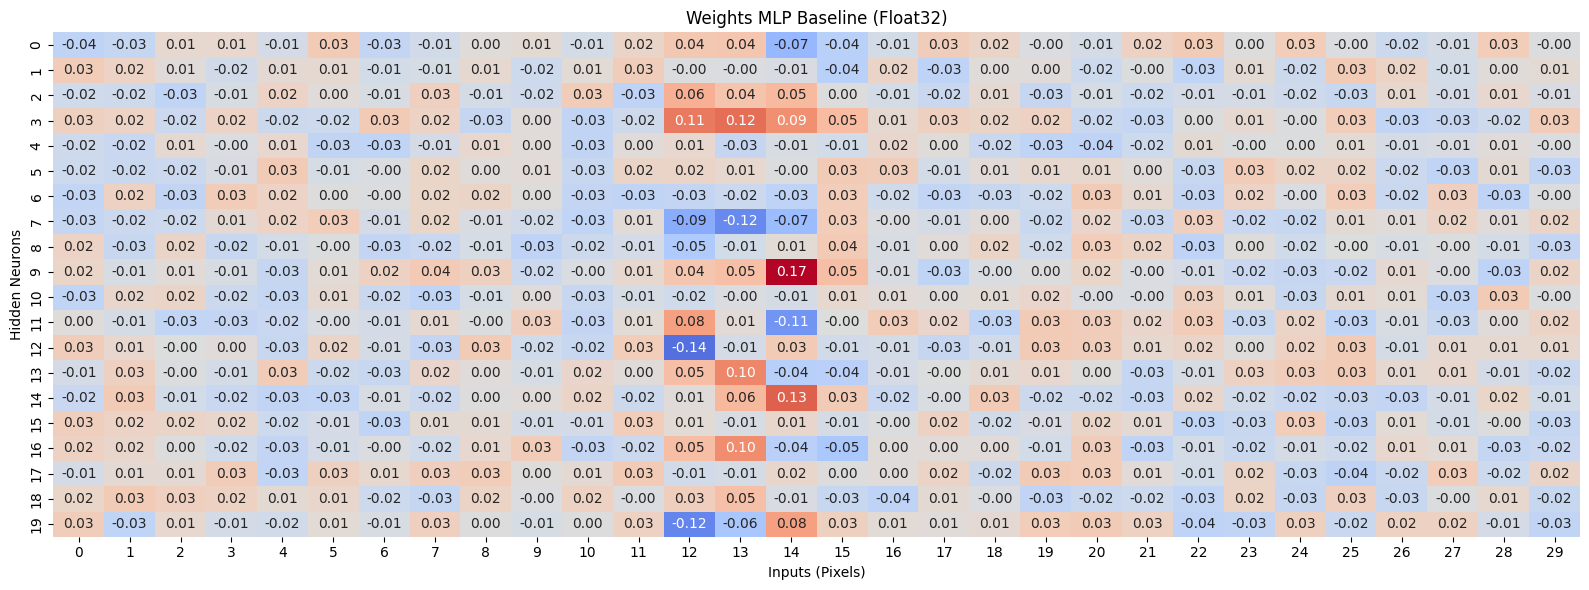

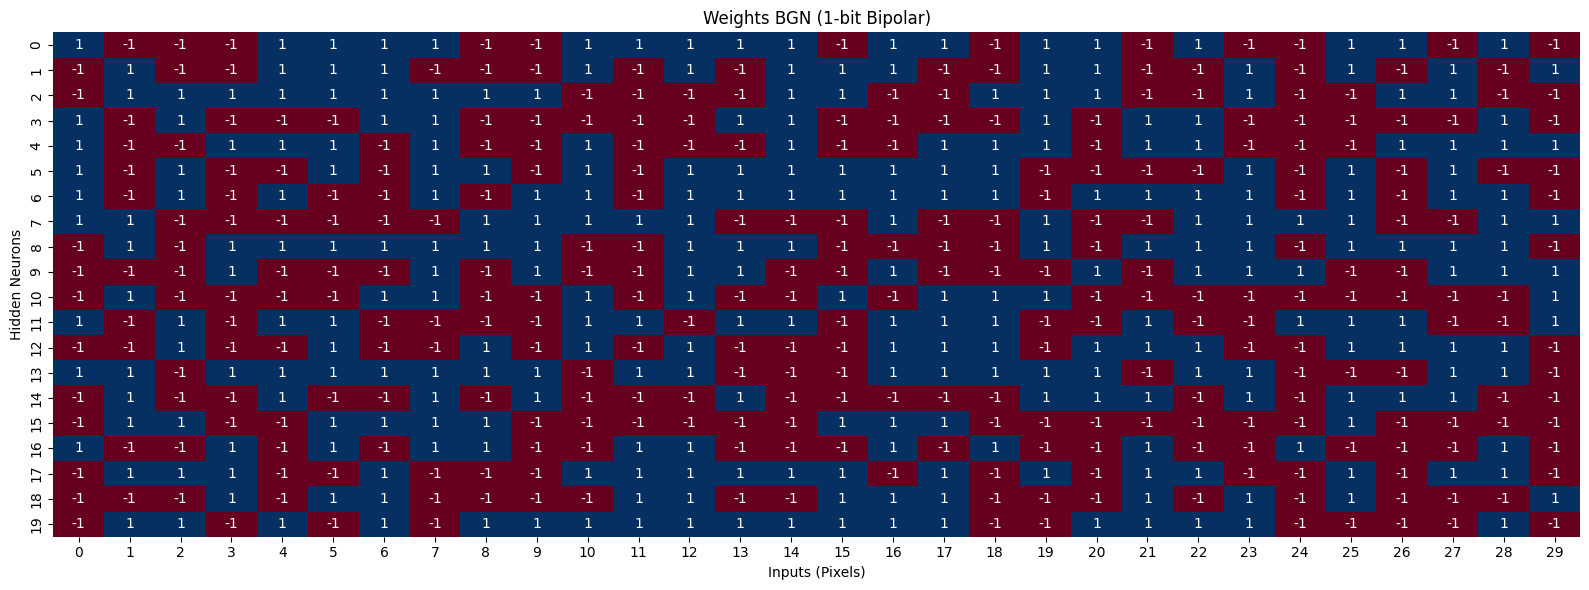

In [320]:
plot_weights_mlp(mlp, n_neurons=20, n_inputs=30)
plot_weights_bgn(bgn, n_neurons=20, n_inputs=30)

# 7. Test

In [321]:
evaluate_model(mlp, test_loader, device, name="MLP (Baseline)")
evaluate_model(bgn, test_loader, device, name="MLP (BGN)")


[FINAL EVALUATION: MLP (Baseline)]
Test Samples: 10000
Average Loss: 0.0798
Accuracy:     9770/10000 (97.70%)

[FINAL EVALUATION: MLP (BGN)]
Test Samples: 10000
Average Loss: 0.1150
Accuracy:     9642/10000 (96.42%)


96.42

# 8. Export do FPGA

In [322]:
def export_hardware_final(model, filename="weights.h"):
    model.eval()
    with torch.no_grad():
        # 1. Layer 1: Pesos Binários com PACKING de 32 bits
        w1_raw = (model.layer1.weights.cpu().numpy() > 0).astype(np.uint8)
        w1_packed = []
        
        for row in range(w1_raw.shape[0]):
            for i in range(0, 800, 32): 
                word = 0
                chunk = w1_raw[row, i:i+32] if i < 784 else np.zeros(32)
                for b in range(len(chunk)):
                    if b < len(chunk) and chunk[b] == 1:
                        word |= (1 << (31 - b))
                w1_packed.append(f"0x{word:08X}")

        # 2. BN1: Parâmetros de 16 bits
        std = torch.sqrt(model.bn1.running_var + 1e-5)
        scale_bn = model.bn1.weight / std
        offset_bn = model.bn1.bias - (scale_bn * model.bn1.running_mean)
        
        bn_scale_int = np.round(scale_bn.cpu().numpy() * 256).astype(np.int16)
        bn_offset_int = np.round(offset_bn.cpu().numpy() * 256).astype(np.int16)
        
        # 3. Layer 2: Pesos e Bias de 8 bits
        w2_int8 = np.clip(np.round(model.layer2.weight.cpu().numpy() * 64), -128, 127).astype(np.int8)
        b2_int8 = np.clip(np.round(model.layer2.bias.cpu().numpy() * 64), -128, 127).astype(np.int8)

    with open(filename, "w") as f:
        f.write("#ifndef WEIGHTS_H\n#define WEIGHTS_H\n#include <stdint.h>\n\n")
        
        # CORREÇÃO DO JOIN: Convertemos a sublista em uma string de itens separados por vírgula
        f.write(f"const uint32_t weights_l1[{len(w1_packed)}] = {{\n")
        for i in range(0, len(w1_packed), 25):
            line = ", ".join(w1_packed[i:i+25])
            f.write(f"    {line},\n")
        f.write("};\n\n")
        
        f.write(f"const int16_t bn_scale[{bn_scale_int.size}] = {{ {','.join(map(str, bn_scale_int))} }};\n")
        f.write(f"const int16_t bn_offset[{bn_offset_int.size}] = {{ {','.join(map(str, bn_offset_int))} }};\n")
        f.write(f"const int8_t weights_l2[{w2_int8.size}] = {{ {','.join(map(str, w2_int8.flatten()))} }};\n")
        f.write(f"const int8_t bias_l2[{b2_int8.size}] = {{ {','.join(map(str, b2_int8.flatten()))} }};\n")
        f.write("\n#endif")
    print(f"File {filename} exported correctly with 32-bit packing.")

# Verificação rápida de segurança
print(f"Neurônios na camada BN: {bgn.bn1.weight.numel()}") 
print(f"Total de pesos na Layer 2: {bgn.layer2.weight.numel()}")
export_hardware_final(bgn)


Neurônios na camada BN: 128
Total de pesos na Layer 2: 1280
File weights.h exported correctly with 32-bit packing.


# 9. FPGA Validation

In [ ]:
def load_weights_final(filename="weights.h", expansion=1):
    with open(filename, 'r') as f:
        content = f.read()

    def extract(name, dtype, base=10):
        pattern = rf"{name}\s*\[.*?\]\s*=\s*\{{(.*?)\}}"
        match = re.search(pattern, content, re.DOTALL)
        if not match:
            raise ValueError(f"Variável {name} não encontrada no arquivo!")
        
        # Remove comentários, quebras de linha e limpa espaços
        clean_content = re.sub(r'//.*', '', match.group(1))
        vals = clean_content.replace('\n', '').split(',')
        
        # Converte considerando a base (16 para hex, 10 para o resto)
        return np.array([int(v.strip(), base) for v in vals if v.strip()], dtype=dtype)

    # 1. Extrair Pesos da L1 (Empacotados em 32 bits)
    w1_packed = extract("weights_l1", np.uint32, base=16)
    
    # 2. Unpack dos bits para o formato (640, 784)
    # Precisamos transformar cada uint32 em 32 valores individuais {-1, 1}
    num_neurons = 128 * expansion
    w1_unpacked = []
    
    for i in range(num_neurons):
        neuron_words = w1_packed[i*25 : (i+1)*25]
        bits = []
        for word in neuron_words:
            # Extrai os 32 bits respeitando a ordem (31-b) que usamos no export
            for b in range(32):
                bit = (word >> (31 - b)) & 1
                bits.append(bit)
        # Cortamos em 784 (removendo o padding de 16 bits da última palavra)
        w1_unpacked.append(bits[:784])
    
    # Converte para bipolar {-1, 1} como o simulador espera
    w1_bipolar = (np.array(w1_unpacked) * 2 - 1).astype(np.int8)

    return {
        'w1': w1_bipolar,
        'bn_s': extract("bn_scale", np.int16),
        'bn_o': extract("bn_offset", np.int16),
        'w2': extract("weights_l2", np.int8).reshape(10, 640),
        'b2': extract("bias_l2", np.int8)
    }



def fpga_inference_final(input_tensor, weights):
    # 1. Entrada Binarizada (Simulando o input_img[25] do HLS)
    # No HLS, pixels > 0.5 viram bit 1. Aqui convertemos para {-1, 1}
    # para usar np.dot como equivalente matemático do XNOR-Popcount.

    if torch.is_tensor(input_tensor):
        x = input_tensor.detach().cpu().numpy().flatten()
    else:
        x = input_tensor.flatten()
            
    x = (x > 0.5).astype(np.int16) * 2 - 1

    # 2. Layer 1 (Equivalente ao XNOR-Popcount)
    # O np.dot entre {-1, 1} e pesos {-1, 1} é matematicamente idêntico a:
    # (2 * popcount(XNOR(in, w))) - num_bits
    w1 = weights['w1'] # Já deve estar em {-1, 1} vindo do load_weights_final
    x_layer1 = np.dot(w1.astype(np.int32), x.astype(np.int32))
    
    # 3. Batch Norm (16-bit Fixed Point)
    # Simula exatamente: (bipolar_val * scale + offset) >> 8
    bn_s = weights['bn_s'].astype(np.int32)
    bn_o = weights['bn_o'].astype(np.int32)
    x_bn = (x_layer1 * bn_s + bn_o) // 256
    
    # 4. ReLU (Garante que valores negativos viram 0)
    x_relu = np.maximum(0, x_bn).astype(np.int16)
    
    # 5. Layer 2 (8-bit Weights)
    # Simula exatamente: (accumulator >> 6) + bias
    w2 = weights['w2'].astype(np.int32)
    b2 = weights['b2'].astype(np.int32)
    
    # Acumulador de alta precisão antes do shift
    acc_l2 = np.dot(w2, x_relu.astype(np.int32))
    output = (acc_l2 // 64) + b2
    
    return np.argmax(output), output

weights = load_weights_final("weights.h")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (640,) + inhomogeneous part.

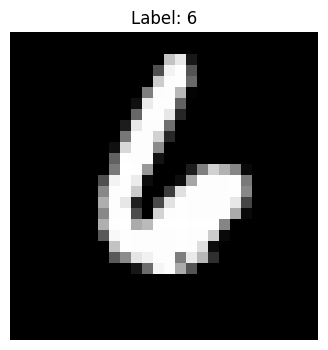

6
FPGA Simulated Prediction: 6


In [305]:
import random

image, label = test_dataset[random.randint(0, len(test_dataset)-1)]

show_sample(image, label)

print(label)

pred, scores = fpga_inference_final(image, weights)
print(f"FPGA Simulated Prediction: {pred}")

In [306]:
def calculate_hardware_footprint_table(weights_dict):
    """
    Calcula o footprint real e exibe em formato de tabela para o relatório do ITA.
    Sincronizada com o pipeline de 1/16/8 bits.
    """
    # 1. Layer 1: Binária (1 bit por parâmetro)
    p1 = weights_dict['w1'].size
    s1 = p1 / (8 * 1024) # Tamanho em KB (Bits / 8 / 1024)
    
    # 2. BN1: INT16 (Scale + Offset)
    # Cada parâmetro int16 ocupa 2 bytes (16 bits)
    p_bn = weights_dict['bn_s'].size + weights_dict['bn_o'].size
    s_bn = (p_bn * 2) / 1024 # Tamanho em KB
    
    # 3. Layer 2: INT8 (Weights + Bias)
    # Cada parâmetro int8 ocupa 1 byte (8 bits)
    p2 = weights_dict['w2'].size + weights_dict['b2'].size
    s2 = p2 / 1024 # Tamanho em KB
    
    # Totais
    total_params = p1 + p_bn + p2
    total_kb = s1 + s_bn + s2
    
    # Cálculo de Bit-width médio (ponderado pela quantidade de parâmetros)
    avg_bitwidth = ((p1 * 1) + (p_bn * 16) + (p2 * 8)) / total_params

    # Formatação da Tabela
    header = f"{'Layer Name':<26} | {'Type':<15} | {'Parameters':<12} | {'Bit-width':<9} | {'Size (KB)':<9}"
    sep = "-" * 84
    
    print("\n--- FINAL HARDWARE FOOTPRINT (MIXED PRECISION) ---")
    print(header)
    print(sep)
    print(f"{'layer1 (weights)':<26} | {'BGN (1-bit)':<15} | {p1:<12,} | {1.0:>9.1f} | {s1:>10.2f}")
    print(f"{'bn1 (scale/offset)':<26} | {'INT16':<15} | {p_bn:<12,} | {16.0:>8.1f} | {s_bn:>10.2f}")
    print(f"{'layer2 (weights/bias)':<26} | {'INT8':<15} | {p2:<12,} | {8.0:>9.1f} | {s2:>10.2f}")
    print(sep)
    print(f"{'TOTAL':<26} | {'':<15} | {total_params:<12,} | AVG: {avg_bitwidth:>5.1f} | {total_kb:>7.2f} KB")
    
    # Métrica de Viabilidade para o Zynq-7020 (560 KB de BRAM disponível)
    usage_pct = (total_kb / 560) * 100
    print(f"Zynq-7020 BRAM Usage: {usage_pct:.2f}%")
    print(sep + "\n")

# Execução
calculate_hardware_footprint_table(weights)


--- FINAL HARDWARE FOOTPRINT (MIXED PRECISION) ---
Layer Name                 | Type            | Parameters   | Bit-width | Size (KB)
------------------------------------------------------------------------------------
layer1 (weights)           | BGN (1-bit)     | 501,760      |       1.0 |      61.25
bn1 (scale/offset)         | INT16           | 1,280        |     16.0 |       2.50
layer2 (weights/bias)      | INT8            | 6,410        |       8.0 |       6.26
------------------------------------------------------------------------------------
TOTAL                      |                 | 509,450      | AVG:   1.1 |   70.01 KB
Zynq-7020 BRAM Usage: 12.50%
------------------------------------------------------------------------------------



# 10. Test Bench

In [272]:
# Binariza e empacota em 32 bits
bits = (image.flatten().numpy() > 0.5).astype(np.uint32)
packed = []
for i in range(0, 784, 32):
    word = 0
    chunk = bits[i:i+32]
    for b in range(len(chunk)):
        word |= (int(chunk[b]) << b)
    packed.append(f"0x{word:08X}")

print(f"// Image Label: {label}")
print("ap_uint<32> test_image[25] = {" + ", ".join(packed) + "};")

// Image Label: 6
ap_uint<32> test_image[25] = {0x00000000, 0x00000000, 0x00000000, 0x000000E0, 0x7000000F, 0x03800000, 0x001C0000, 0x0000E000, 0x00000E00, 0x80000070, 0x38000003, 0x01C00000, 0x07DC0000, 0x00FEC000, 0x000DEE00, 0x0000C660, 0x40000E06, 0xE4000070, 0x0FC00003, 0x00380000, 0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000};


In [284]:
import numpy as np

def generate_hls_test_bench_image(image_tensor, label):
    """
    Converte um tensor de imagem em um array C++ de 25 palavras (32-bit).
    Aplica binarização estrita (threshold 0.5).
    """
    # 1. Binarização: Transforma escala de cinza em 0 ou 1
    # Valores > 0.5 viram 1, o restante vira 0
    binary_image = (image_tensor.flatten().numpy() > 0.5).astype(np.uint8)
    
    # 2. Padding: Garante que temos 800 bits (25 palavras de 32 bits)
    # 784 pixels originais + 16 bits de zero para fechar a última palavra
    padded_bits = np.zeros(800, dtype=np.uint8)
    padded_bits[:784] = binary_image
    
    packed_words = []
    
    # 3. Empacotamento em palavras de 32 bits
    for i in range(0, 800, 32):
        word = 0
        chunk = padded_bits[i:i+32]
        for b in range(len(chunk)):
            # Posicionando cada pixel em seu bit correspondente (0 a 31)
            if chunk[b] == 1:
                # word |= (1 << b)
                word |= (1 << (31 - b))
                
        packed_words.append(f"0x{word:08X}")

    # 4. Saída formatada para o C++
    print(f"// --- Test Image for Label: {label} ---")
    print(f"// Binarized pixel count (1s): {np.sum(binary_image)}")
    print("ap_uint<32> test_image[25] = {")
    print("    " + ", ".join(packed_words[:5]) + ",")
    print("    " + ", ".join(packed_words[5:10]) + ",")
    print("    " + ", ".join(packed_words[10:15]) + ",")
    print("    " + ", ".join(packed_words[15:20]) + ",")
    print("    " + ", ".join(packed_words[20:25]))
    print("};")

# Exemplo de uso com o primeiro item do seu test_subset
# img, lbl = test_subset[0]
generate_hls_test_bench_image(image, label)

// --- Test Image for Label: 6 ---
// Binarized pixel count (1s): 90
ap_uint<32> test_image[25] = {
    0x00000000, 0x00000000, 0x00000000, 0x07000000, 0xF000000E,
    0x000001C0, 0x00003800, 0x00070000, 0x00700000, 0x0E000001,
    0xC000001C, 0x00000380, 0x00003BE0, 0x00037F00, 0x0077B000,
    0x06630000, 0x60700002, 0x0E000027, 0xC00003F0, 0x00001C00,
    0x00000000, 0x00000000, 0x00000000, 0x00000000, 0x00000000
};
